In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import folium as foli

In [ ]:
import warnings
from scipy import stats
warnings.filterwarnings("ignore")
import statsmodels.formula.api as smf
from datetime import datetime, timedelta
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
#Installing lightweight_mmm Libarary tool
!pip install --upgrade git+https://github.com/google/lightweight_mmm.git

  Cloning https://github.com/google/lightweight_mmm.git to /tmp/pip-req-build-e5k3yb63
  Running command git clone --filter=blob:none --quiet https://github.com/google/lightweight_mmm.git /tmp/pip-req-build-e5k3yb63
  Resolved https://github.com/google/lightweight_mmm.git to commit b4c99fa7532b767b7c3b519e41f8dffa15ab8c65
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.0/285.0 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 50.9 MB/s eta 0:00:00
  Created wheel for lightweight-mmm: filename=lightweight_mmm-0.1.9-py3-none-any.whl size=105289 sha256=99e0b9b66a33885b4f05fabd80099d2d367d40f1b9fad257ef84b3b6a03cd892
  Stored in directory: /tmp/pip-ephem-wheel-cache-cql5t2ae/wh

In [ ]:
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro


# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

In [ ]:
#Raw data from the internet. Not sure if it's real or stimulated
df = pd.read_csv("https://raw.githubusercontent.com/sibylhe/mmm_stan/main/data.csv")

In [ ]:
df.head()

,wk_strt_dt,yr_nbr,qtr_nbr,prd,wk_nbr,wk_in_yr_nbr,mdip_dm,mdip_inst,mdip_nsp,mdip_auddig,...,seas_prd_12,seas_week_40,seas_week_41,seas_week_42,seas_week_43,seas_week_44,seas_week_45,seas_week_46,seas_week_47,seas_week_48
0,2014-08-03,2014,3,7,1,27,4863885,29087520,2421933,692315,...,0,0,0,0,0,0,0,0,0,0
1,2014-08-10,2014,3,7,2,28,20887502,8345120,3984494,475810,...,0,0,0,0,0,0,0,0,0,0
2,2014-08-17,2014,3,7,3,29,11097724,17276800,1846832,784732,...,0,0,0,0,0,0,0,0,0,0
3,2014-08-24,2014,3,7,4,30,1023446,18468480,2394834,1032301,...,0,0,0,0,0,0,0,0,0,0
4,2014-08-31,2014,3,8,1,31,21109811,26659920,3312008,400456,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 1. media variables
# media spending (Simplified media channel for demo)
mdsp_cols=[col for col in df.columns if 'mdsp_' in col and col !='mdsp_viddig' and col != 'mdsp_auddig' and col != 'mdsp_sem']


# 2. control variables
# holiday variables
hldy_cols = [col for col in df.columns if 'hldy_' in col]
# seasonality variables
seas_cols = [col for col in df.columns if 'seas_' in col]

control_vars =  hldy_cols + seas_cols



# 3. sales variables
sales_cols =['sales']

df_main = df[['wk_strt_dt']+sales_cols+mdsp_cols+control_vars]
df_main = df_main.rename(columns={'mdsp_dm': 'Direct Mail', 'mdsp_inst': 'Insert', 'mdsp_nsp': 'Newspaper', 'mdsp_audtr': 'Radio', 'mdsp_vidtr': 'TV', 'mdsp_so': 'Social Media', 'mdsp_on': 'Online Display'})
mdsp_cols = ["Direct Mail","Insert", "Newspaper", "Radio", "TV", "Social Media", "Online Display"]


In [ ]:
pd.set_option('display.max_rows', 50)
from IPython.core.pylabtools import figsize
df_main.head()

,wk_strt_dt,sales,Direct Mail,Insert,Newspaper,Radio,TV,Social Media,Online Display,hldy_Black Friday,...,seas_prd_12,seas_week_40,seas_week_41,seas_week_42,seas_week_43,seas_week_44,seas_week_45,seas_week_46,seas_week_47,seas_week_48
0,2014-08-03,72051457.64,678410.26,129759.66,507635.16,254134.14,216725.59,0.0,61364.75,0,...,0,0,0,0,0,0,0,0,0,0
1,2014-08-10,78794770.54,661097.71,70355.33,625719.37,106602.98,108919.26,0.0,132643.90,0,...,0,0,0,0,0,0,0,0,0,0
2,2014-08-17,70071185.56,1874338.43,107720.37,277532.61,59011.42,74032.19,0.0,76741.27,0,...,0,0,0,0,0,0,0,0,0,0
3,2014-08-24,68642464.59,306583.37,141708.61,186028.61,178010.46,110995.66,0.0,193043.55,0,...,0,0,0,0,0,0,0,0,0,0
4,2014-08-31,86190784.65,2366274.16,160691.30,706694.09,144097.56,225140.84,0.0,249612.89,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Process Data by splitting into train and test.
#Testing the last 24 weeks for testing in this case
SEED = 105
data_size = len(df_main)

n_media_channels = len(mdsp_cols)
n_extra_features = len(control_vars)
media_data = df_main[mdsp_cols].to_numpy()
extra_features = df_main[control_vars].to_numpy()
target = df_main['sales'].to_numpy()
costs = df_main[mdsp_cols].sum().to_numpy()

# Split and scale data.
test_data_period_size = 24
split_point = data_size - test_data_period_size
# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]
# Extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]
# Target
target_train = target[:split_point]

In [ ]:
# The code below divides the media spending data, extra features data,
#and the target data by their mean to ensure that the result has a mean of 1.
#This allows the model to be agnostic to the scale of the inputs.

media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)



In [ ]:
#Next Step is Trainig.
#Ad stock function for modeling from 3 options
#1. Hill-ad stock
#2. Ad Stock
#3. Carryover

mmm = lightweight_mmm.LightweightMMM(model_name="hill_adstock")
mmm.fit( media=media_data_train, media_prior=costs, target=target_train,
        extra_features=extra_features_train, media_names = mdsp_cols, seed=SEED)




sample: 100%|██████████| 2000/2000 [03:24<00:00,  9.76it/s, 1023 steps of size 2.07e-03. acc. prob=0.90]


In [ ]:
mmm.print_summary()


                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             coef_extra_features[0]      0.03      0.84      0.03     -1.28      1.46    458.16      1.00
             coef_extra_features[1]      0.11      0.70      0.12     -1.03      1.23    307.40      1.00
             coef_extra_features[2]     -0.01      0.01     -0.01     -0.03     -0.00    444.81      1.01
             coef_extra_features[3]      0.00      0.00      0.00     -0.00      0.01    972.87      1.00
             coef_extra_features[4]     -0.06      0.71     -0.07     -1.28      1.07    321.58      1.00
             coef_extra_features[5]     -0.09      0.70     -0.11     -1.22      1.04    308.07      1.00
             coef_extra_features[6]     -0.01      0.00     -0.01     -0.01     -0.00   1543.44      1.00
             coef_extra_features[7]     -0.00      0.00     -0.00     -0.01      0.00   1124.42      1.00
             coef_extra_features[8]     -0.02

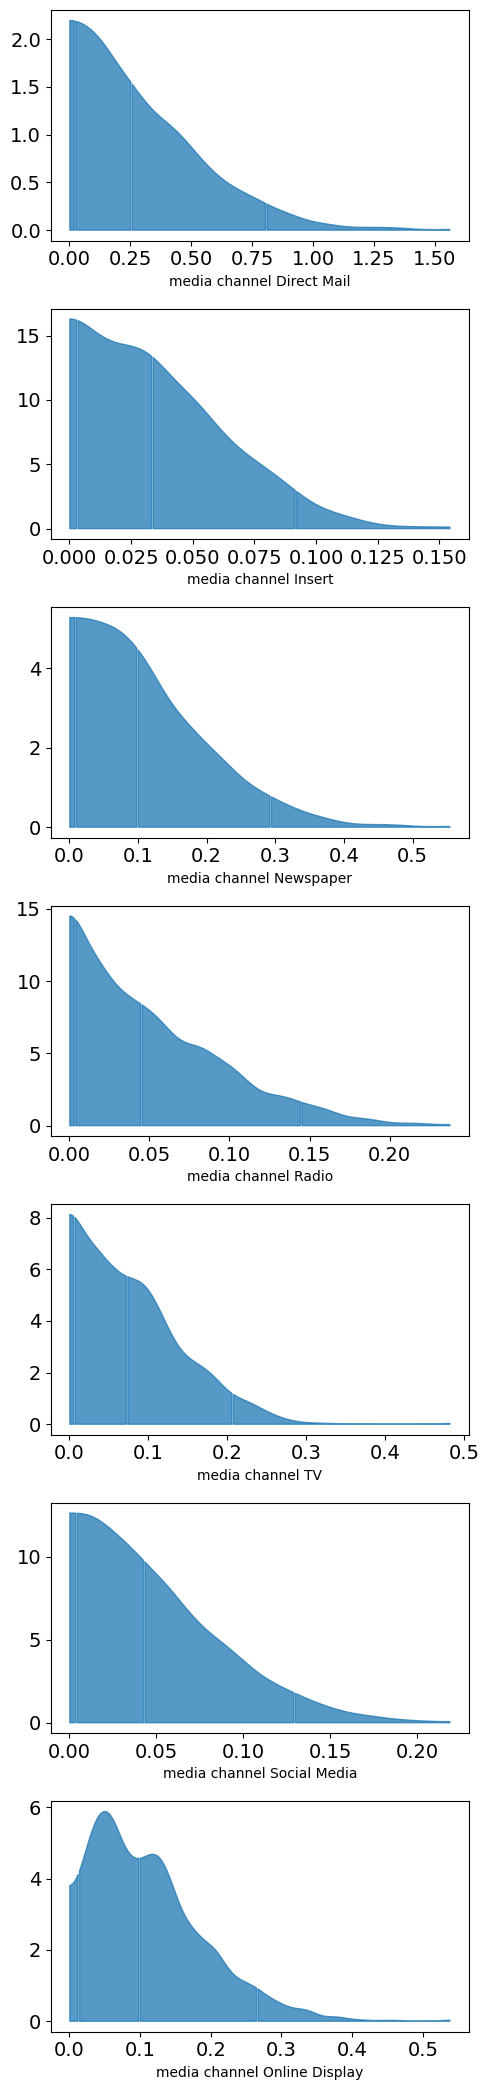

In [ ]:
#For above Summary, Check whether the r_hat values for all parameters are < 1.1

#Let Visulize the the Posterior Distribution of media effects
plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names=mdsp_cols)

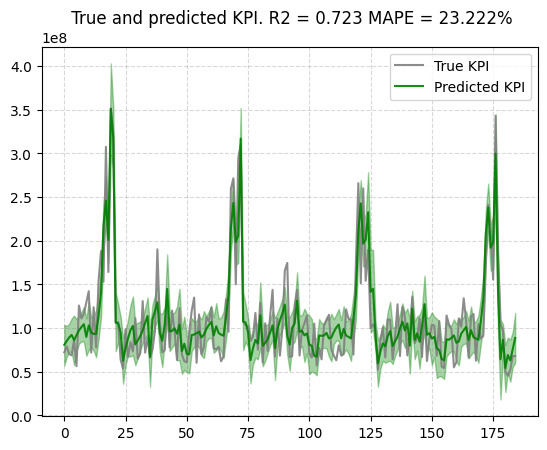

In [ ]:
#Fitting CheCk
plot.plot_model_fit(mmm, target_scaler=target_scaler)

In [ ]:
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
    out_of_sample_target=target_scaler.transform(target[split_point:]))

TypeError: ignored

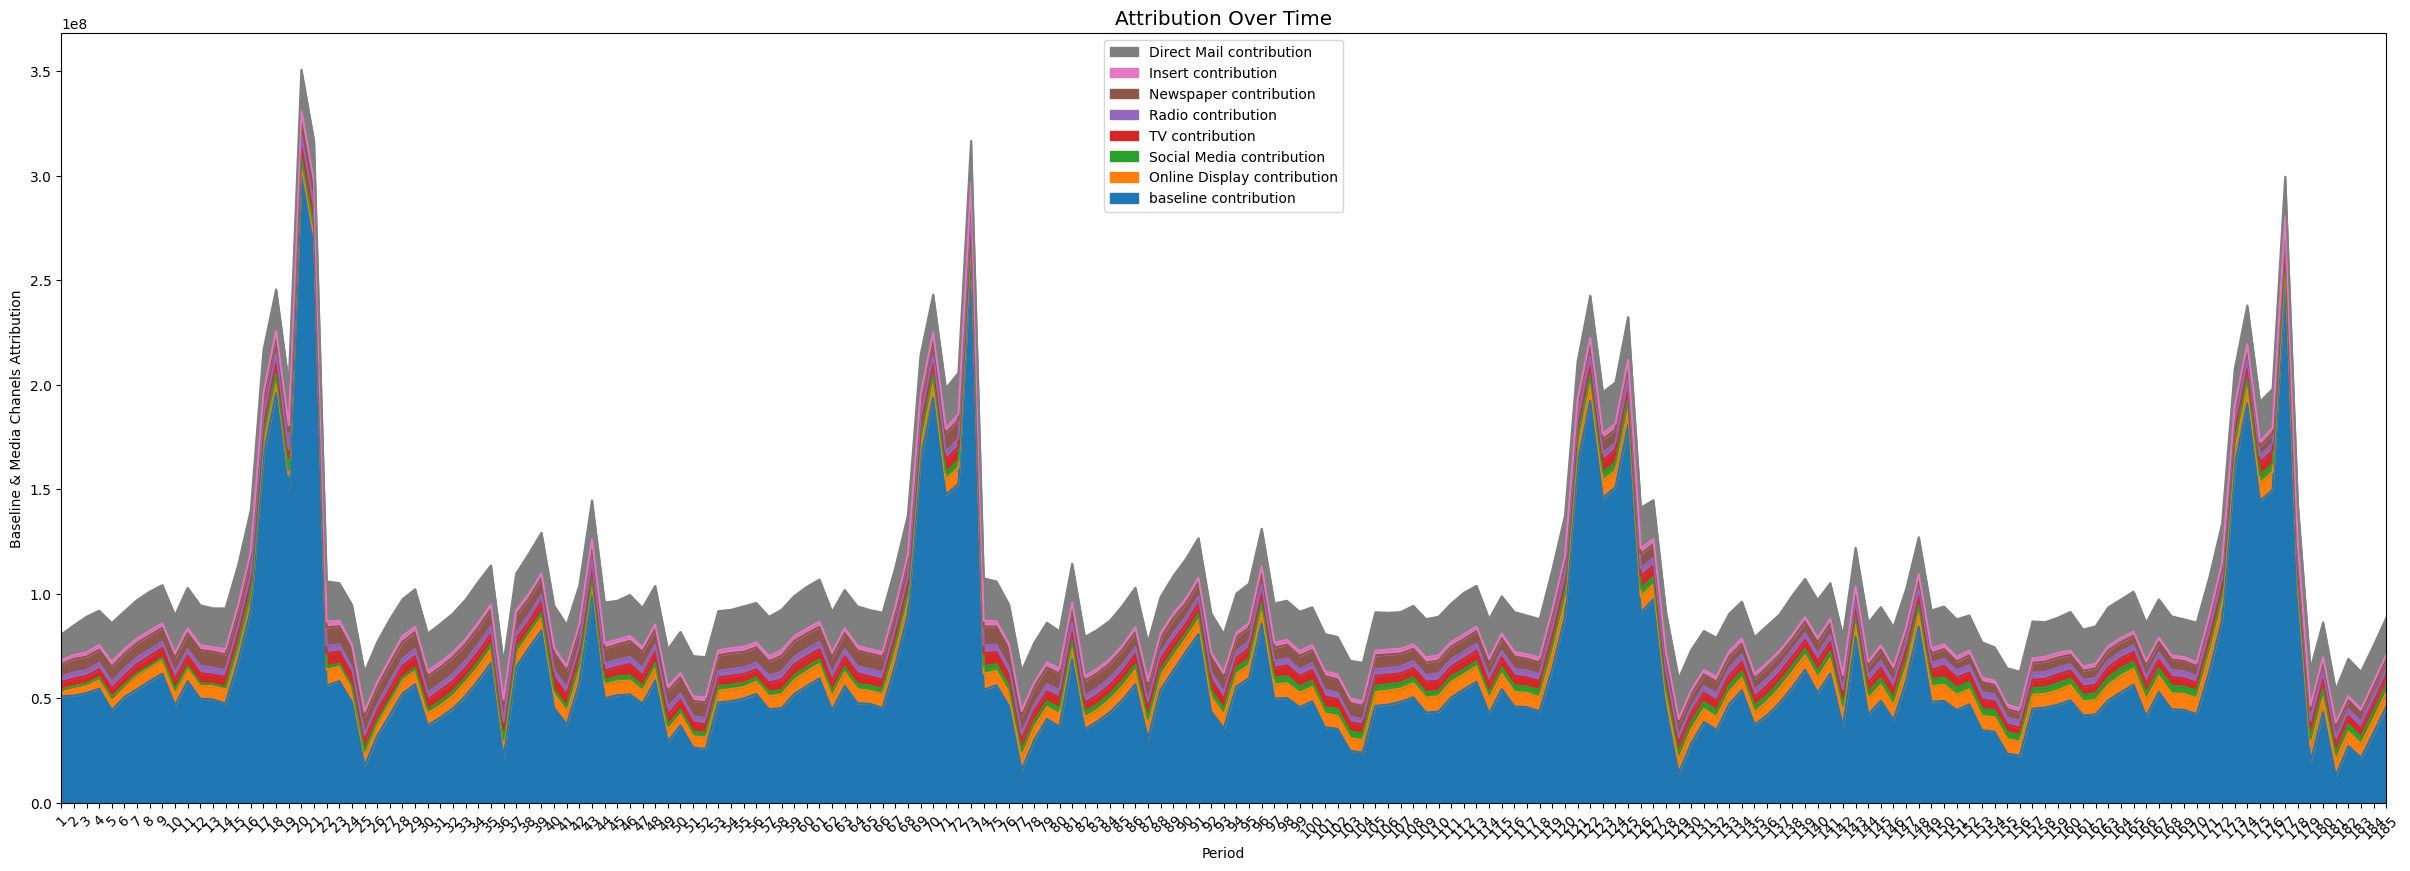

In [ ]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10),
                                                channel_names = mdsp_cols
                                                )

In [ ]:
#The graph Above shows that about 70% of sales are baseline sales, which is represented by the blue area.


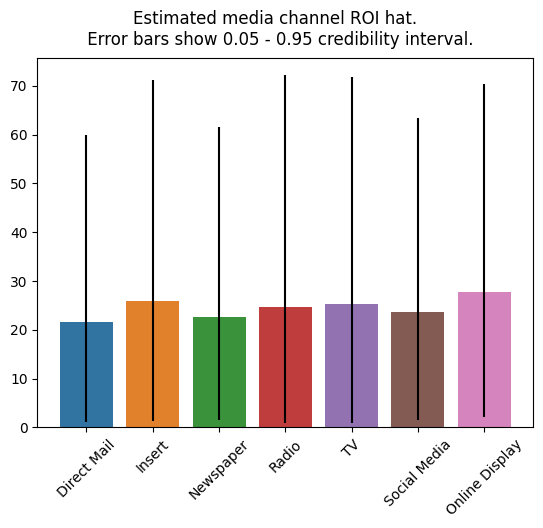

In [ ]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat", channel_names=mdsp_cols)

In [ ]:
#Each bar represents how efficient the ROI of the media is. In this case,
#TV and Online Display are more efficient than other media.

In [ ]:
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm,
                                                kpi_with_optim=solution['fun'],
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation,
                                                previous_budget_allocation=previous_budget_allocation,
                                                figure_size=(10,10),
                                                channel_names = mdsp_cols)

NameError: ignored